<a href="https://colab.research.google.com/github/sharsulkar/H1B_LCA_outcome_prediction/blob/main/prototyping/notebooks/04_sh_train_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [158]:
import pandas as pd
import numpy as np
np.random.seed(42)
import random
from sklearn.metrics import plot_confusion_matrix,confusion_matrix
import matplotlib.pyplot as plt 
from sklearn.metrics import f1_score
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, IsolationForest
from sklearn.cluster import KMeans
from sklearn.svm import OneClassSVM
%matplotlib inline

In [ ]:
#source and encode the output variable
Y=pd.read_excel('https://www.dol.gov/sites/dolgov/files/ETA/oflc/pdfs/LCA_Disclosure_Data_FY2020_Q2.xlsx',usecols=['CASE_STATUS'])
drop_row_index=Y[~Y.CASE_STATUS.isin(['Certified','Denied'])].index
Y.drop(index=drop_row_index, inplace=True)
Y.reset_index(inplace=True,drop=True)
Y.replace(['Certified','Denied'],[0,1],inplace=True)

In [4]:
#import features from saved file 
processed_df=pd.read_csv('/content/drive/MyDrive/Datasets/LCA_train_q1q2processed.csv',index_col=0)
Y=pd.read_csv('/content/drive/MyDrive/Datasets/LCA_train_q1q2_expected.csv',index_col=0)
processed_df.shape

(256141, 31)

In [9]:
#Add the target column back to processed_df as it will be used in generate_train_val_batches function
Y.replace(['Certified','Denied'],[0,1],inplace=True)
processed_df['CASE_STATUS']=Y

In [138]:
#algorithm to create mini batches where each batch has a equal distribution of both classes
class_count=2 #number of classes to predict
batch_size=500 #batch size of train+val dataset
val_size=0.2 #validation data % within batch

#collection of indexes for both classes from the entire training dataset
class_0_index=processed_df[processed_df.CASE_STATUS==0].index 
class_1_index=processed_df[processed_df.CASE_STATUS==1].index

In [34]:
def generate_train_val_batches(df,class_0_index,class_1_index,class_count,batch_size,val_size):
  #Generate batches to output training and val data 
  #randomly select indexes of batch size/class_count from the index collection for the entire dataset
  idx_0=random.sample(set(class_0_index.values),int(batch_size/class_count)) 
  idx_1=random.sample(set(class_1_index.values),int(batch_size/class_count))

  #split the indexes into train and val datasets within the selected batch
  split_value=int((batch_size*val_size)/class_count)
  idx_train=idx_0[split_value:]+idx_1[split_value:]
  idx_val=idx_0[:split_value]+idx_1[:split_value]

  #Generate the train and val datasets using the indexes selected in previous step
  X_train=df.loc[idx_train]
  X_val=df.loc[idx_val].reset_index(drop=True)
  y_val=X_val.pop('CASE_STATUS').astype(int)
  #https://stackoverflow.com/questions/29576430/shuffle-dataframe-rows
  X_train=X_train.sample(frac=1).reset_index(drop=True)
  y_train=X_train.pop('CASE_STATUS').astype(int)

  return X_train, y_train, X_val, y_val

In [16]:
#skewness between classes - class 1 is only 0.7% of total
class_1_index.shape[0]*100/(class_0_index.shape[0]+class_1_index.shape[0])

0.7181748749661239

In [159]:
svc=SGDClassifier(loss='hinge')
logistic=SGDClassifier(loss='log')
adaboost=AdaBoostClassifier()
rfc=RandomForestClassifier()
kmeans=KMeans(n_clusters=2)
iforest=IsolationForest(contamination=0.01)
ocsvm=OneClassSVM(kernel = 'rbf', gamma = 0.001, nu = 0.001)

In [168]:
#loop over 
for _ in range(100):
  X_train, y_train, X_val, y_val=generate_train_val_batches(processed_df,class_0_index,class_1_index,class_count,batch_size,val_size)
  #train classifiers on batches
  for model in [svc,logistic,adaboost,rfc]:
    model.fit(X_train,y_train)
    #print(f1_score(y_true=y_val,y_pred=model.predict(X_val)))


In [162]:
class_count=2 #number of classes to predict
batch_size=3400 #batch size of train+val dataset
val_size=0.2 #validation data % within batch
for _ in range(10):
  X_train, y_train, X_val, y_val=generate_train_val_batches(processed_df,class_0_index,class_1_index,class_count,batch_size,val_size)
  iforest.fit(X_train)
  y_pred=iforest.predict(X_val)
  y_pred=np.where(y_pred==1,0,y_pred)
  y_pred=np.where(y_pred==-1,1,y_pred)
  print(f1_score(y_true=y_val,y_pred=y_pred,average=None))

[0.66929134 0.02325581]
[0.66666667 0.02312139]
[0.66403162 0.02298851]
[0.6679803  0.02318841]
[0.66468843 0.0286533 ]
[0.66666667 0.04545455]
[0.66600791 0.02873563]
[0.66338583 0.00581395]
[0.66732478 0.02881844]
[0.66666667 0.01166181]


In [163]:
class_count=2 #number of classes to predict
batch_size=3400 #batch size of train+val dataset
val_size=0.2 #validation data % within batch
for _ in range(10):
  X_train, y_train, X_val, y_val=generate_train_val_batches(processed_df,class_0_index,class_1_index,class_count,batch_size,val_size)
  ocsvm.fit(X_train)
  y_pred=ocsvm.predict(X_val)
  y_pred=np.where(y_pred==1,0,y_pred)
  y_pred=np.where(y_pred==-1,1,y_pred)
  print(f1_score(y_true=y_val,y_pred=y_pred,average=None))

[0.66666667 0.01166181]
[0.6647001 0.0058309]
[0.6647001 0.0058309]
[0.66338583 0.00581395]
[0.6673209 0.0058651]
[0.66666667 0.        ]
[0.66141732 0.        ]
[0.66601179 0.00584795]
[0.66338583 0.00581395]
[0.66601179 0.00584795]


In [166]:
class_count=2 #number of classes to predict
batch_size=3400 #batch size of train+val dataset
val_size=0.2 #validation data % within batch
for _ in range(10):
  X_train, y_train, X_val, y_val=generate_train_val_batches(processed_df,class_0_index,class_1_index,class_count,batch_size,val_size)
  kmeans.fit(X_train,y_train)
  print(f1_score(y_true=y_val,y_pred=kmeans.predict(X_val),average=None))


[0.02873563 0.66600791]
[0.66600595 0.03988604]
[0.66403162 0.02298851]
[0.66600985 0.0173913 ]
[0.66732673 0.04      ]
[0.66204163 0.02849003]
[0.66005946 0.02279202]
[0.03428571 0.66534653]
[0.66206897 0.0057971 ]
[0.01162791 0.66535433]


In [142]:
X_test=pd.read_csv('/content/drive/MyDrive/Datasets/LCA_test_q3processed.csv',index_col=0)
y_test=pd.read_csv('/content/drive/MyDrive/Datasets/LCA_test_q3_expected.csv',index_col=0)
y_test.replace(['Certified','Denied'],[0,1],inplace=True)
y_test=y_test.astype(int)

In [169]:
print(f1_score(y_true=y_test,y_pred=svc.predict(X_test),average='weighted'))
print(f1_score(y_true=y_test,y_pred=svc.predict(X_test),average=None))
print(f1_score(y_true=y_test,y_pred=adaboost.predict(X_test),average='weighted'))
print(f1_score(y_true=y_test,y_pred=adaboost.predict(X_test),average=None))
print(f1_score(y_true=y_test,y_pred=rfc.predict(X_test),average='weighted'))
print(f1_score(y_true=y_test,y_pred=rfc.predict(X_test),average=None))
print(f1_score(y_true=y_test,y_pred=logistic.predict(X_test),average='weighted'))
print(f1_score(y_true=y_test,y_pred=logistic.predict(X_test),average=None))
print(f1_score(y_true=y_test,y_pred=kmeans.predict(X_test),average='weighted'))
print(f1_score(y_true=y_test,y_pred=kmeans.predict(X_test),average=None))

0.6907902371873986
[0.6966426  0.02686773]
0.6105738972030541
[0.61573491 0.02508128]
0.7125822782834473
[0.71878545 0.00886237]
0.8531958587055237
[0.86070796 0.00098368]
0.014643267166267368
[0.01461862 0.01743967]


In [144]:
print(f1_score(y_true=y_train,y_pred=svc.predict(X_train),average=None))
print(f1_score(y_true=y_train,y_pred=adaboost.predict(X_train),average=None))
print(f1_score(y_true=y_train,y_pred=rfc.predict(X_train),average=None))
print(f1_score(y_true=y_train,y_pred=logistic.predict(X_train),average=None))
print(f1_score(y_true=y_train,y_pred=kmeans.predict(X_train),average=None))

[0.61365552 0.26900585]
[0.50693069 0.5728988 ]
[0.65663717 0.75597484]
[0.62774534 0.27346717]
[0.66320475 0.0243553 ]


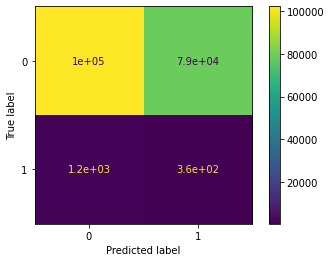

In [170]:
plot_confusion_matrix(rfc,X_test,y_test)

In [171]:
confusion_matrix(y_true=y_test,y_pred=svc.predict(X_test))
#plot_confusion_matrix(svc,X_test,y_test)

array([[97066, 84106],
       [  430,  1167]])

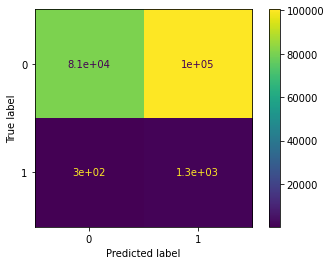

In [172]:
plot_confusion_matrix(adaboost,X_test,y_test)

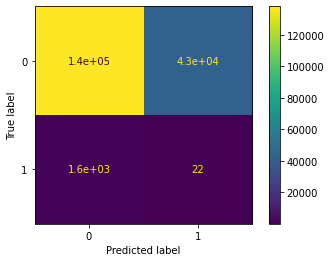

In [173]:
plot_confusion_matrix(logistic,X_test,y_test)